# Dublin City Area analysis


## Summary

### The problem

Many new businesses fail to make profit within their first three years of opening (59% in the hospitality and services industry, according to a study by Dr. HG Parsa).

A particularly difficult area of business is the restaurant/food and grocery store industry. This industry is oversaturated and highly competitive. For this reason, new business owners hoping to open a resaurant r grocery store, in an already saturated market, should aim to find a location for opening their business that gives them the best possible chance for success.    

### Audience
The intended audience for this project is business people who plan to start a new Grocery store business (specifically looking to locate that business in the Dublin city area).

### Data sources

* Foursquare will be used to gather restaurant data
* Geographical location data will be scraped from the following website: [wikipedia.com](https://en.wikipedia.org/wiki/List_of_Dublin_postal_districts)
* Mapbox API will be used to get geographical latitude and longituide coordinates

### Proposed solution 

This project will analyse the postal code areas of Dublin, Ireland. Data about the given areas will be collected using the Foursquare API. 
Geographical information will be retrieved from the web using the python library BeautifulSoup as well as the mapbox API.  

The data from Foursquare will be used to cluster the areas into groups based on the number of specific amenities in the local areas. This data will then be used to 
make recommendations to business owners about the location of optimalm area for setting up a new business.

#### Foursquare sample response
Bellow is a sample JSON response from the Foursquare API. In this project we will be using the latitude and longitude coordinates of restaurants across Dublin city in order to get an idea of how saurated the grocery store market is within each postal code. We can then use this information to look at areas of lower saturation as possinble locations for a new business.


```json
{
  "meta": {
    "code": 200,
    "requestId": "5ac51d7e6a607143d811cecb"
  },
  "response": {
    "venues": [
      {
        "id": "5642aef9498e51025cf4a7a5",
        "name": "Mr. Purple",
        "location": {
          "address": "180 Orchard St",
          "crossStreet": "btwn Houston & Stanton St",
          "lat": 40.72173744277209,
          "lng": -73.98800687282996,
          "labeledLatLngs": [
            {
              "label": "display",
              "lat": 40.72173744277209,
              "lng": -73.98800687282996
            }
          ],
          "distance": 8,
          "postalCode": "10002",
          "cc": "US",
          "city": "New York",
          "state": "NY",
          "country": "United States",
          "formattedAddress": [
            "180 Orchard St (btwn Houston & Stanton St)",
            "New York, NY 10002",
            "United States"
          ]
        },
        "categories": [
          {
            "id": "4bf58dd8d48988d1d5941735",
            "name": "Hotel Bar",
            "pluralName": "Hotel Bars",
            "shortName": "Hotel Bar",
            "icon": {
              "prefix": "https://ss3.4sqi.net/img/categories_v2/travel/hotel_bar_",
              "suffix": ".png"
            },
            "primary": true
          }
        ],
        "venuePage": {
          "id": "150747252"
        }
      }
    ]
  }
}
```

In [1]:
#Import libraries and dependencies

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#Beutiful soup for scraping website data
from bs4 import BeautifulSoup as bfs


print("libraries and dependencies imported")

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be 

## Scrape location data from wikipedia

In [56]:
from urllib.request import urlopen
#Scrape neighbourhood data from wikipedia
page = 'https://en.wikipedia.org/wiki/List_of_Dublin_postal_districts'

page = urlopen(page).read()
soup = bfs(page)
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of Dublin postal districts - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgMonthNamesShort":["","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],"wgRequestId":"XiNJdgpAAD4AAIVwE2QAAAEQ","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_Dublin_postal_districts","wgTitle":"List of Dublin postal districts","wgCurRevisionId":935513594,"wgRevisionId":935513594,"wgArticleId":961703,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Use Irish Eng

In [3]:
#Select the list containing area codes and names
table = soup.find('table',{'class':'wikitable'})

#extract area codes from the list
area_codes = []
ul = table.find_next('ul')

for item in ul.findAll('li'):
    area_codes.append(item.text[6:9].strip())
    
print(area_codes)



#extract area names of area codes
place_names = []
area_names = []

for item in ul.findAll('li'):
    item_list = []
    for name in item.findAll('a'):
        if name.text[0] != "[":
            if "4" not in name.text and "embassies" not in name.text and "RDS" not in name.text:
                item_list.append(name.text)
    place_names.append([item_list])
    
for name_list in place_names:
    area_names.append(name_list[0])
    
print(area_names)

    

#check we have listed the correct number of areas and area codes
print("Areas: ",len(area_names))
print("Area codes: ",len(area_codes))


['1', '2', '3', '4', '5', '6', '6W', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '20', '22', '24']
[['Abbey Street', 'Amiens Street', 'Dorset Street', 'Henry Street', 'Mountjoy Square', 'Marlborough Street', 'North Wall', "O'Connell Street", 'Parnell Square', 'Talbot Street'], ['River Liffey', 'Merrion Square', 'Trinity College', 'Temple Bar', 'Grafton Street', "St Stephen's Green", 'Dame Street', 'Leeson Street', 'Leinster House', 'Government Buildings', 'Mansion House', 'Grand Canal'], ['Ballybough', 'North Strand', 'Clonliffe', 'Clontarf', 'Dollymount', 'East Wall', 'East Point', 'Fairview', 'Killester', 'Marino'], ['Ballsbridge', 'Belfield', 'Donnybrook', 'Irishtown', 'Merrion', 'Pembroke', 'Ringsend', 'Sandymount', 'Lansdowne Road'], ['Artane', 'Coolock', 'Harmonstown', 'Kilbarrack', 'Raheny'], ['Milltown', 'Ranelagh', 'Terenure', 'Rathmines', 'Dartry', 'Rathgar'], ["Harold's Cross", 'Templeogue', 'Kimmage', 'Terenure'], ['Arbour Hill', 'Ashtown', 'Broadst

## Create a dataframe of our scraped geographical info

In [57]:
d = {'Area codes':area_codes,'Place names':area_names}
df = pd.DataFrame(d)
df

,Area codes,Place names
0,1,"[Abbey Street, Amiens Street, Dorset Street, H..."
1,2,"[River Liffey, Merrion Square, Trinity College..."
2,3,"[Ballybough, North Strand, Clonliffe, Clontarf..."
3,4,"[Ballsbridge, Belfield, Donnybrook, Irishtown,..."
4,5,"[Artane, Coolock, Harmonstown, Kilbarrack, Rah..."
5,6,"[Milltown, Ranelagh, Terenure, Rathmines, Dart..."
6,6W,"[Harold's Cross, Templeogue, Kimmage, Terenure]"
7,7,"[Arbour Hill, Ashtown, Broadstone, Cabra, Gran..."
8,8,"[Dolphin's Barn, Inchicore, Islandbridge, Kilm..."
9,9,"[Ballymun, Beaumont, Donnycarney, Drumcondra, ..."


## Use the Mapquest API to get latitude and longitude coordinates of each area code

In [58]:
#mapquest api key
api_key = "L6usbRLxMTfJPewfI7qJOkSA2QiYWdo6"

In [59]:
coordinates = []

def get_coords():
    for area in area_codes:
            area_code = area
            url = "https://www.mapquestapi.com/geocoding/v1/address?key="+api_key+"&location=dublin "+area_code+", ireland"
            coords = requests.get(url).json()["results"][0]["locations"][0]["latLng"]
            lat=coords["lat"]
            lon=coords["lng"]
            coordinates.append([area_code, lat, lon])
    print(coordinates)


get_coords()




[['1', 53.352565, -6.256647], ['2', 53.338923, -6.252702], ['3', 53.361246, -6.185515], ['4', 53.327655, -6.227492], ['5', 53.383656, -6.181606], ['6', 53.317884, -6.259986], ['6W', 53.306082, -6.300782], ['7', 53.36043, -6.284417], ['8', 53.350404, -6.320374], ['9', 53.385823, -6.245707], ['10', 53.343185, -6.361034], ['11', 53.386611, -6.292611], ['12', 53.320503, -6.326052], ['13', 53.385664, -6.07539], ['14', 53.298643, -6.258169], ['15', 53.394888, -6.389837], ['16', 53.274847, -6.275795], ['17', 53.40019, -6.209734], ['18', 53.251471, -6.190675], ['20', 53.352297, -6.372346], ['22', 53.328966, -6.405117], ['24', 53.291577, -6.368967]]


In [61]:
coords_df = pd.DataFrame(coordinates)
coords_df.columns = ['Area codes','Latitude', 'Longitude']
coords_df

,Area codes,Latitude,Longitude
0,1,53.352565,-6.256647
1,2,53.338923,-6.252702
2,3,53.361246,-6.185515
3,4,53.327655,-6.227492
4,5,53.383656,-6.181606
5,6,53.317884,-6.259986
6,6W,53.306082,-6.300782
7,7,53.360430,-6.284417
8,8,53.350404,-6.320374
9,9,53.385823,-6.245707


## Join the place name dataframe with the coordinates dataframe

In [62]:
#Merge the cleaned_df dataframe with the coords dataframe
merged_df = pd.merge(left=df,right=coords_df, left_on='Area codes', right_on='Area codes')
# take a look at the head of our newnly created dataframe
merged_df

,Area codes,Place names,Latitude,Longitude
0,1,"[Abbey Street, Amiens Street, Dorset Street, H...",53.352565,-6.256647
1,2,"[River Liffey, Merrion Square, Trinity College...",53.338923,-6.252702
2,3,"[Ballybough, North Strand, Clonliffe, Clontarf...",53.361246,-6.185515
3,4,"[Ballsbridge, Belfield, Donnybrook, Irishtown,...",53.327655,-6.227492
4,5,"[Artane, Coolock, Harmonstown, Kilbarrack, Rah...",53.383656,-6.181606
5,6,"[Milltown, Ranelagh, Terenure, Rathmines, Dart...",53.317884,-6.259986
6,6W,"[Harold's Cross, Templeogue, Kimmage, Terenure]",53.306082,-6.300782
7,7,"[Arbour Hill, Ashtown, Broadstone, Cabra, Gran...",53.360430,-6.284417
8,8,"[Dolphin's Barn, Inchicore, Islandbridge, Kilm...",53.350404,-6.320374
9,9,"[Ballymun, Beaumont, Donnycarney, Drumcondra, ...",53.385823,-6.245707


In [63]:
dublin_lat= 53.352565
dublin_lon= -6.256647

# create map of Dublin using latitude and longitude values
map_dublin = folium.Map(location=[dublin_lat, dublin_lon], zoom_start=10)

# add markers to map
for lat, lng, area in zip(merged_df['Latitude'], merged_df['Longitude'], merged_df['Area codes']):
    label = 'Dublin {}'.format(area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dublin)  
    
map_dublin

## Let's get data on each area code using the Foursquare API

In [64]:
# The code was removed by Watson Studio for sharing.

### Retrieve JSON formatted data from the Foursquare API

In [65]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area code', 
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [66]:
#Run the function above to retrieve Foursquare data on the neighbourhoods 
dublin_venues = getNearbyVenues(names=merged_df['Area codes'],
                                   latitudes=merged_df['Latitude'],
                                   longitudes=merged_df['Longitude']
                                  )

1
2
3
4
5
6
6W
7
8
9
10
11
12
13
14
15
16
17
18
20
22
24


In [67]:
# Check the size of the dataframe
print(dublin_venues.shape)
dublin_venues.head()

(836, 7)


,Area code,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,53.352565,-6.256647,147 Deli,53.353410,-6.259807,Deli / Bodega
1,1,53.352565,-6.256647,Holiday Inn Express Dublin City Centre Hotel,53.352182,-6.260848,Hotel
2,1,53.352565,-6.256647,The Celt,53.350442,-6.255071,Pub
3,1,53.352565,-6.256647,The Hop House (Kim Chi),53.352981,-6.260772,Korean Restaurant
4,1,53.352565,-6.256647,Murray's Bar,53.352419,-6.261256,Pub


In [68]:
#Show number of venues per area code
counts = dublin_venues.groupby('Area code').count()
counts

,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Area code,,,,,,
1,100,100,100,100,100,100
10,7,7,7,7,7,7
11,4,4,4,4,4,4
12,29,29,29,29,29,29
13,52,52,52,52,52,52
14,27,27,27,27,27,27
15,67,67,67,67,67,67
16,12,12,12,12,12,12
17,11,11,11,11,11,11


In [69]:
#Calculate number of unique venues 
print('There are {} uniques categories.'.format(len(dublin_venues['Venue Category'].unique())))

There are 165 uniques categories.


### Let's vizualise that as a bar chart

In [70]:
venue_count = []
area_code_indx = []
indexed_counts = counts.index

i=0
for count in counts['Venue Category']:
    venue_count.append(counts['Venue Category'][i])
    area_code_indx.append(indexed_counts[i])
    i+= 1
    

print(area_code_indx)
print(venue_count)

['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '2', '20', '22', '24', '3', '4', '5', '6', '6W', '7', '8', '9']
[100, 7, 4, 29, 52, 27, 67, 12, 11, 33, 100, 12, 11, 40, 20, 89, 18, 95, 22, 37, 11, 39]


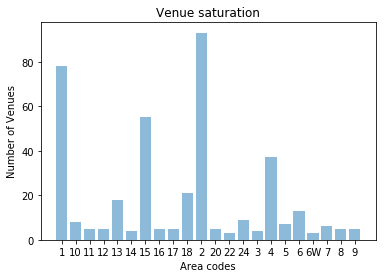

In [40]:
import matplotlib.pyplot as plt
y_pos = np.arange(len(area_code_indx))

plt.bar(y_pos, venue_count, align='center', alpha=0.5)
plt.xticks(y_pos, area_code_indx)
plt.ylabel('Number of Venues')
plt.xlabel('Area codes')
plt.title('Venue saturation')

plt.show()

Looking at this bar chart we can see area codes 1, 2, 4, and 15 have a high saturation of public venues. These areas may not be the best 
location for a new grocery store due to the high levels of public venues already in the areas. Let's explore an area with a lower public 
venue saturation. We'll take a look at Dublin 13. This area has a much lower public venue sauturation level but is still relatively busy 
compared to the rest of the areas around Dublin.

## Exploring Dublin 13

In [71]:
#Get area names for dublin 13
D13_names = area_names[13]
print(D13_names)

['Baldoyle', 'Bayside', 'Donaghmede', 'Sutton', 'Howth', 'Ayrfield']


In [72]:
#Get the coordinates of each area in Dublin 13
area_coordinates = []

def get_area_coords():
    for area in area_names[13]:
            area_name = area
            url = "https://www.mapquestapi.com/geocoding/v1/address?key="+api_key+"&location="+area_name+",dublin, ireland"
            coords = requests.get(url).json()["results"][0]["locations"][0]["latLng"]
            lat=coords["lat"]
            lon=coords["lng"]
            area_coordinates.append([area_name, lat, lon])
    print(area_coordinates)


get_area_coords()

[['Baldoyle', 53.39176, -6.12473], ['Bayside', 53.39122, -6.14043], ['Donaghmede', 53.3923, -6.15759], ['Sutton', 53.39052, -6.105711], ['Howth', 53.387856, -6.065355], ['Ayrfield', 53.39363, -6.18612]]


In [74]:
dublin13_df = pd.DataFrame(area_coordinates)
dublin13_df.columns = ['Area name', 'Latitude', 'Longitude']
dublin13_df

,Area name,Latitude,Longitude
0,Baldoyle,53.391760,-6.124730
1,Bayside,53.391220,-6.140430
2,Donaghmede,53.392300,-6.157590
3,Sutton,53.390520,-6.105711
4,Howth,53.387856,-6.065355
5,Ayrfield,53.393630,-6.186120


### Let's vizualise these areas on a map

In [75]:
dublin13_lat= 53.385664
dublin13_lon= -6.075390

# create map of Dublin using latitude and longitude values
map_dublin13 = folium.Map(location=[dublin13_lat, dublin13_lon], zoom_start=12)

# add markers to map
for lat, lng, area in zip(dublin13_df['Latitude'], dublin13_df['Longitude'], dublin13_df['Area name']):
    label = 'Dublin 13 {}'.format(area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dublin13)  
    
map_dublin13

In [76]:
#Run the getNearbyVenues function with our new values to retrieve Foursquare data on the neighbourhoods 
dublin13_venues = getNearbyVenues(names=dublin13_df['Area name'],
                                   latitudes=dublin13_df['Latitude'],
                                   longitudes=dublin13_df['Longitude']
                                  )

Baldoyle
Bayside
Donaghmede
Sutton
Howth
Ayrfield


In [77]:
# Check the size of the dataframe
print(dublin13_venues.shape)
dublin13_venues.head()

(131, 7)


,Area code,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Baldoyle,53.39176,-6.12473,Elphin,53.389260,-6.123891,Bar
1,Baldoyle,53.39176,-6.12473,The White House,53.398132,-6.127041,Gastropub
2,Baldoyle,53.39176,-6.12473,Minetta Deli,53.389878,-6.110443,Deli / Bodega
3,Baldoyle,53.39176,-6.12473,Insomnia,53.389628,-6.110309,Café
4,Baldoyle,53.39176,-6.12473,Sutton Dart Station,53.391877,-6.116295,Train Station


In [79]:
#Show number of venues per area code
d13_venue_counts = dublin13_venues.groupby('Area code').count()


#Calculate number of unique venues 
print('There are {} uniques categories.'.format(len(dublin13_venues['Venue Category'].unique())))

d13_venue_counts

There are 54 uniques categories.


,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Area code,,,,,,
Ayrfield,21,21,21,21,21,21
Baldoyle,14,14,14,14,14,14
Bayside,14,14,14,14,14,14
Donaghmede,14,14,14,14,14,14
Howth,52,52,52,52,52,52
Sutton,16,16,16,16,16,16


### Let's visualise that with a barchart

In [80]:
d13_venue_count = []
area_indx = []
d13_indexed_counts = d13_venue_counts.index

i=0
for count in d13_venue_counts['Venue Category']:
    d13_venue_count.append(d13_venue_counts['Venue Category'][i])
    area_indx.append(d13_indexed_counts[i])
    i+= 1
    

print(area_indx)
print(d13_venue_count)

['Ayrfield', 'Baldoyle', 'Bayside', 'Donaghmede', 'Howth', 'Sutton']
[21, 14, 14, 14, 52, 16]


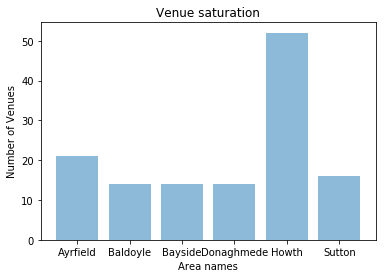

In [81]:
y_pos = np.arange(len(area_indx))

plt.bar(y_pos, d13_venue_count, align='center', alpha=0.5)
plt.xticks(y_pos, area_indx)
plt.ylabel('Number of Venues')
plt.xlabel('Area names')
plt.title('Venue saturation')

plt.show()

### Analyse each place name in the Dublin 13 area

In [82]:
# one hot encoding
d13_onehot = pd.get_dummies(dublin13_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
d13_onehot['Area name'] = dublin13_venues['Area code'] 

# move neighborhood column to the first column
fixed_columns = [d13_onehot.columns[-1]] + list(d13_onehot.columns[:-1])
d13_onehot = d13_onehot[fixed_columns]

d13_onehot.head()

,Area name,Asian Restaurant,Auto Garage,Badminton Court,Bakery,Bar,Beach,Bowling Alley,Breakfast Spot,Burger Joint,Bus Stop,Café,Castle,Chinese Restaurant,Coffee Shop,Convenience Store,Deli / Bodega,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Gastropub,Golf Course,Grocery Store,Harbor / Marina,Health Food Store,Hotel,Hungarian Restaurant,Ice Cream Shop,Indoor Play Area,Irish Pub,Italian Restaurant,Lighthouse,Mobile Phone Shop,Movie Theater,Museum,Pet Store,Pharmacy,Pier,Pizza Place,Pub,Rugby Pitch,Seafood Restaurant,Shopping Mall,Soccer Field,Supermarket,Surf Spot,Tea Room,Tennis Court,Thai Restaurant,Trail,Train Station,Video Game Store,Wine Shop
0,Baldoyle,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Baldoyle,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Baldoyle,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Baldoyle,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Baldoyle,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### Group rows by Area name and by taking the mean of the frequency of occurrence of each category

In [83]:
d13_grouped = d13_onehot.groupby('Area name').mean().reset_index()
d13_grouped

,Area name,Asian Restaurant,Auto Garage,Badminton Court,Bakery,Bar,Beach,Bowling Alley,Breakfast Spot,Burger Joint,Bus Stop,Café,Castle,Chinese Restaurant,Coffee Shop,Convenience Store,Deli / Bodega,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Gastropub,Golf Course,Grocery Store,Harbor / Marina,Health Food Store,Hotel,Hungarian Restaurant,Ice Cream Shop,Indoor Play Area,Irish Pub,Italian Restaurant,Lighthouse,Mobile Phone Shop,Movie Theater,Museum,Pet Store,Pharmacy,Pier,Pizza Place,Pub,Rugby Pitch,Seafood Restaurant,Shopping Mall,Soccer Field,Supermarket,Surf Spot,Tea Room,Tennis Court,Thai Restaurant,Trail,Train Station,Video Game Store,Wine Shop
0,Ayrfield,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.047619,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.047619,0.047619,0.000000,0.047619,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.095238,0.000000,0.047619,0.0000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.047619,0.047619,0.000000,0.047619,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.095238,0.0000,0.000000,0.0000,0.0000,0.000000,0.000000,0.047619,0.000000
1,Baldoyle,0.000000,0.000000,0.000000,0.000000,0.142857,0.071429,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.071429,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.0000,0.000000,0.142857,0.000000,0.000000
2,Bayside,0.000000,0.071429,0.071429,0.000000,0.142857,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.071429,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.071429,0.0000,0.000000,0.0000,0.0000,0.000000,0.071429,0.000000,0.071429
3,Donaghmede,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.071429,0.071429,0.142857,0.0000,0.000000,0.0000,0.0000,0.000000,0.142857,0.000000,0.071429
4,Howth,0.019231,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.019231,0.000000,0.000000,0.096154,0.019231,0.000000,0.057692,0.019231,0.038462,0.000000,0.019231,0.000000,0.019231,0.038462,0.038462,0.000000,0.019231,0.038462,0.000000,0.0000,0.019231,0.057692,0.000000,0.019231,0.000000,0.038462,0.000000,0.000000,0.019231,0.000000,0.000000,0.019231,0.000000,0.096154,0.000000,0.192308,0.000000,0.000000,0.000000,0.0000,0.019231,0.0000,0.0000,0.019231,0.019231,0.000000,0.000000
5,Sutton,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.062500,0.125000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.062500,0.0625,0.000000,0.0625,0.0625,0.000000,0.062500,0.000000,0.000000


In [103]:
len(d13_grouped[d13_grouped["Grocery Store"] > 0])

4

In [106]:
d13_grocery = d13_grouped[["Area name","Grocery Store"]]
d13_grocery

,Area name,Grocery Store
0,Ayrfield,0.095238
1,Baldoyle,0.000000
2,Bayside,0.142857
3,Donaghmede,0.142857
4,Howth,0.019231
5,Sutton,0.000000


## Cluster Areas
Run k-means to cluster the areas into 3 clusters

In [107]:
# set number of clusters
kclusters = 3

d13_grocery_clustering = d13_grocery.drop('Area name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(d13_grocery_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 1, 1, 0, 0], dtype=int32)

In [109]:
d13_merged = d13_grocery

# add clustering labels
d13_merged['Cluster Labels'] = kmeans.labels_


d13_merged.rename(columns={"Area name": "Area name"}, inplace=True)
d13_merged

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Area name,Grocery Store,Cluster Labels
0,Ayrfield,0.095238,2
1,Baldoyle,0.000000,0
2,Bayside,0.142857,1
3,Donaghmede,0.142857,1
4,Howth,0.019231,0
5,Sutton,0.000000,0


### Look at individual clusters

In [111]:
d13_merged.loc[d13_merged['Cluster Labels'] == 0]

,Area name,Grocery Store,Cluster Labels
1,Baldoyle,0.000000,0
4,Howth,0.019231,0
5,Sutton,0.000000,0


In [112]:
d13_merged.loc[d13_merged['Cluster Labels'] == 1]

,Area name,Grocery Store,Cluster Labels
2,Bayside,0.142857,1
3,Donaghmede,0.142857,1


In [113]:
d13_merged.loc[d13_merged['Cluster Labels'] == 2]

,Area name,Grocery Store,Cluster Labels
0,Ayrfield,0.095238,2


## Results

Looking at the above results we can see that cluster 0 has the lowest percentage of Grocery stores in the clustered
areas. Cluster 1 has the highest concentration of Grocery stores, and cluster 3 has low to moderate number of Grocery stores.
Regarding these measurements it would be advantageous to open a new Grocery store in either of the areas (Bayside, Donaghmede) that
belong to cluster 0.

## Further research

While this project looked at potential areas for opening a new grocery store based on preexisting grocery stores
there are many other data sets that should be investigated in order to create a more thorough report. Some of these data 
may include demographics, affluence, population density, spending trends, and crime rates to name a few.

This project will continue to grow as it integrates more of the above mentioned data sets.